In [1]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
from jaxmarl.environments.coin_game.make_train_RLLIB import make_train_RLLIB        
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Training

In [2]:
# Hiperparámetros
NUM_ENVS = 1
NUM_INNER_STEPS = 50
NUM_EPOCHS = 3000
NUM_AGENTS = 2
SHOW_EVERY_N_EPOCHS = 100
SAVE_EVERY_N_EPOCHS = 500
LR = 1e-4
PAYOFF_MATRIX = [[1, 2, -3], [1, 2, -3]]
GRID_SIZE = 3
REWARD_COEF = [[1, 0], [1, 0]]

In [ ]:
brigit = '/mnt/lustre/home/samuloza'
save_dir = f'{brigit}/data/samuel_lozano/coin_game/pruebas/Prisioner_dilemma/'
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

config = {
    "NUM_ENVS": NUM_ENVS,
    "NUM_INNER_STEPS": NUM_INNER_STEPS,
    "NUM_EPOCHS": NUM_EPOCHS,
    "NUM_AGENTS": NUM_AGENTS,
    "SHOW_EVERY_N_EPOCHS": SHOW_EVERY_N_EPOCHS,
    "SAVE_EVERY_N_EPOCHS": SAVE_EVERY_N_EPOCHS,
    "LR": LR,
    "PAYOFF_MATRIX": PAYOFF_MATRIX,
    "GRID_SIZE": GRID_SIZE,
    "REWARD_COEF": REWARD_COEF,
    "SAVE_DIR": save_dir,
    # RLlib specific parameters
    "NUM_UPDATES": 10,  # Number of updates of the policy
    "GAMMA": 0.995,  # Discount factor
    "GAE_LAMBDA": 0.95,  # GAE-Lambda parameter
    "ENT_COEF": 0.01,  # Entropy coefficient
    "CLIP_EPS": 0.2,  # PPO clip parameter
    "VF_COEF": 0.5  # Value function coefficient
}

trainer, current_date = make_train_RLLIB(config)

/mnt/lustre/home/samuloza/.conda/envs/JaxMARL_TFM/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2025-06-16 15:28:27,539	INFO worker.py:1917 -- Started a local Ray instance.


TypeError: cannot pickle 'Device' object

# Analysis

In [8]:
# Directorios base
brigit = '/mnt/lustre/home/samuloza'
base_dirs = {
    "Prisioner_dilemma": f"{brigit}/data/samuel_lozano/coin_game/Prisioner_dilemma",
    "No_dilemma": f"{brigit}/data/samuel_lozano/coin_game/No_dilemma"
}

output_path = f"{brigit}/data/samuel_lozano/coin_game/training_results.csv"

# Eliminar el archivo CSV si ya existe
if os.path.exists(output_path):
    os.remove(output_path)

In [9]:
all_dfs = []

# Patrón para capturar los coeficientes de recompensa
reward_pattern = re.compile(r"REWARD_COEF:\s*\[\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\],\s*\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\]\]")

In [10]:
for dilemma_name, base_dir in base_dirs.items():
    dilemma_flag = 1 if "Prisioner" in dilemma_name else 0
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        date_time_str = folder.replace("Training_", "")
        config_path = os.path.join(folder_path, "config.txt")
        csv_path = os.path.join(folder_path, "training_stats.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            continue

        with open(config_path, "r") as f:
            config_contents = f.read()
        match = reward_pattern.search(config_contents)
        if not match:
            continue

        alpha_1, beta_1, alpha_2, beta_2 = map(float, match.groups())

        grid_size_match = re.search(r"GRID_SIZE:\s*(\d+)", config_contents)
        grid_size = int(grid_size_match.group(1)) if grid_size_match else -1 

        lr_match = re.search(r"LR:\s*([0-9.eE+-]+)", config_contents)
        lr = float(lr_match.group(1)) 

        df = pd.read_csv(csv_path)

        df.insert(0, "timestamp", date_time_str)
        df.insert(1, "dilemma", dilemma_flag)
        df.insert(2, "alpha_1", alpha_1)
        df.insert(3, "beta_1", beta_1)
        df.insert(4, "alpha_2", alpha_2)
        df.insert(5, "beta_2", beta_2)
        df.insert(6, "grid_size", grid_size)
        df.insert(7, "lr", lr)

        all_dfs.append(df)

In [11]:
# Concatenar todos los resultados
final_df = pd.concat(all_dfs, ignore_index=True)
final_df.to_csv(output_path, index=False)

# Visualization

In [12]:
# Leer el CSV especificando los tipos de datos
dtype_dict = {
    "timestamp": str,
    "dilemma": int,
    "alpha_1": float,
    "beta_1": float,
    "alpha_2": float,
    "beta_2": float
}

# Cargar el CSV con conversión explícita al tipo numérico para el resto de columnas
brigit = '/mnt/lustre/home/samuloza'
output_path = f"{brigit}/data/samuel_lozano/coin_game/training_results.csv"

df = pd.read_csv(output_path, dtype=dtype_dict, low_memory=False)
for col in df.columns[6:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear una columna identificadora de combinación de coeficientes
df = df.sort_values(by=["alpha_1", "alpha_2"], ascending=[False, False])
df["attitude_key"] = df.apply(lambda row: f"{row['alpha_1']}_{row['beta_1']}_{row['alpha_2']}_{row['beta_2']}", axis=1)
df["pure_reward_total"] = df["pure_reward_agent_0"] + df["pure_reward_agent_1"]

In [13]:
# Filtrar todas las combinaciones únicas
unique_attitudes = df["attitude_key"].unique()
unique_lr = df["lr"].unique()
unique_dilemma = df["dilemma"].unique()

figures_dir = f"{brigit}/data/samuel_lozano/coin_game/figures/"
os.makedirs(figures_dir, exist_ok=True)

metrics_0 = [
    "own_coin_collected_agent_0",
    "other_coin_collected_agent_0",
    "reject_own_coin_agent_0",
    "reject_other_coin_agent_0",
    "no_coin_visible_agent_0"
]

metrics_1 = [
    "own_coin_collected_agent_1",
    "other_coin_collected_agent_1",
    "reject_own_coin_agent_1",
    "reject_other_coin_agent_1",
    "no_coin_visible_agent_1"
]

In [14]:
# Print Pure total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    plt.figure(figsize=(10, 6))
    
    for dilemma_value in unique_dilemma:
        dilemma_filtered = subset[subset["dilemma"] == dilemma_value]
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
            grouped = lr_filtered.groupby("epoch")["pure_reward_total"].mean().reset_index()
            label = f"Dilemma {dilemma_value}, LR {lr}"
            plt.plot(grouped["epoch"], grouped["pure_reward_total"], label=label)
    
    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    sanitized_attitude = attitude.replace('.', 'p')
    filename = f"pure_reward_attitude_{sanitized_attitude}.png"
    filepath = os.path.join(figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [15]:
# Print Each agent pure total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    for dilemma_value in unique_dilemma:
        dilemma_filtered = subset[subset["dilemma"] == dilemma_value]
    
        # Crear la figura
        plt.figure(figsize=(10, 6))
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
            grouped = lr_filtered.groupby("epoch")[["pure_reward_agent_0", "pure_reward_agent_1"]].mean().reset_index()
            label_0 = f"Agent 0, LR {lr}"
            label_1 = f"Agent 1, LR {lr}"
            plt.plot(grouped["epoch"], grouped["pure_reward_agent_0"], label=label_0)
            plt.plot(grouped["epoch"], grouped["pure_reward_agent_1"], label=label_1)
    
        # Añadir detalles
        plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}, Dilemma {dilemma_value}")
        plt.xlabel("Epoch")
        #plt.xlim([0,100])
        plt.ylabel("Pure Reward Total")
        plt.legend()
        plt.tight_layout()
        
        sanitized_attitude = attitude.replace('.', 'p')
        filename = f"pure_reward_agents_d{dilemma_value}_attitude_{sanitized_attitude}.png"
        filepath = os.path.join(figures_dir, filename)
        plt.savefig(filepath)
        plt.close()

KeyboardInterrupt: 

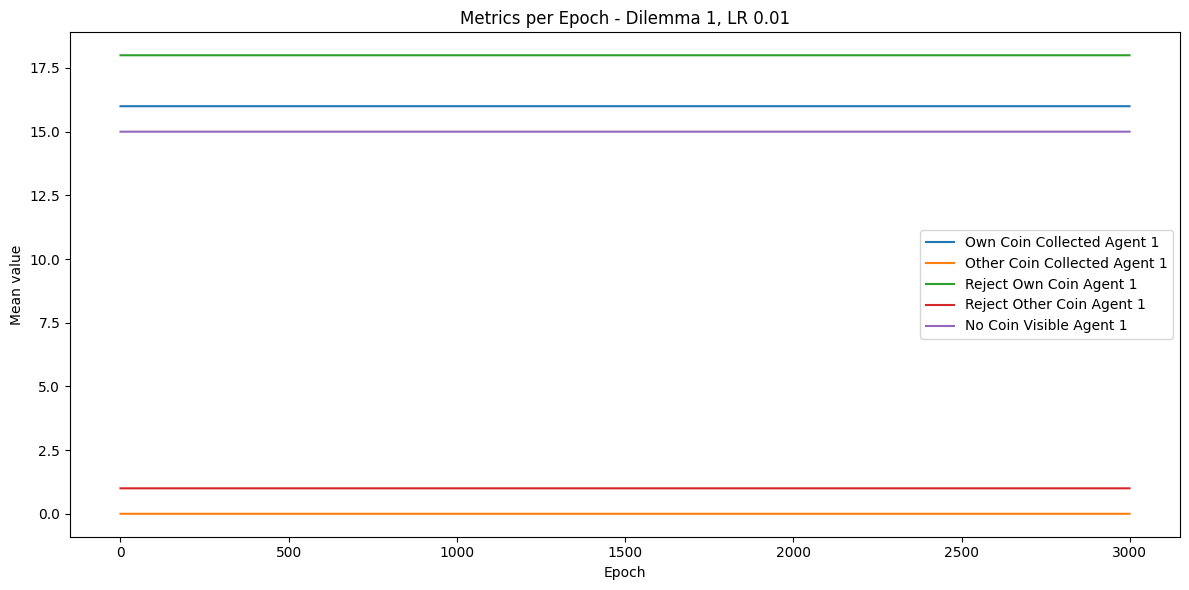

In [16]:
# Print agent metrics vs epoch
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    for dilemma_value in [0, 1]:
        for grid_size in subset["grid_size"].unique():
            for lr in subset["lr"].unique():
                filtered_subset = subset[(subset["dilemma"] == dilemma_value) & (subset["grid_size"] == grid_size) & (subset["lr"] == lr)]
    
                plt.figure(figsize=(12, 6))
                for metric in metrics_0:
                    grouped = filtered_subset.groupby(["epoch"])[metric].mean().reset_index()
                    plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())
                plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
                plt.xlabel("Epoch")
                plt.ylabel("Mean value")
                plt.legend()
                #plt.xlim([0, 100])
                plt.tight_layout()
                
                sanitized_attitude = attitude.replace('.', 'p')
                filename_0 = f"metrics_agent0_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}.png"
                filepath_0 = os.path.join(figures_dir, filename_0)
                plt.savefig(filepath_0)
                plt.close()
    
                plt.figure(figsize=(12, 6))
                for metric in metrics_1:
                    grouped = filtered_subset.groupby(["epoch"])[metric].mean().reset_index()
                    plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())
                plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
                plt.xlabel("Epoch")
                plt.ylabel("Mean value")
                plt.legend()
                #plt.xlim([0, 100])
                plt.tight_layout()

                filename_1 = f"metrics_agent1_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}.png"
                filepath_1 = os.path.join(figures_dir, filename_1)
                plt.savefig(filepath_1)
                plt.close()

## Averaging over attitudes

In [ ]:
# Print Pure total reward vs epoch

plt.figure(figsize=(10, 6))

for dilemma_value in unique_dilemma:
    dilemma_filtered_df = df[df["dilemma"] == dilemma_value]

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered_df = dilemma_filtered_df[dilemma_filtered_df["lr"] == lr]
        grouped = lr_filtered_df.groupby("epoch")["pure_reward_total"].mean().reset_index()
        label = f"Dilemma {dilemma_value}, LR {lr}"
        plt.plot(grouped["epoch"], grouped["pure_reward_total"], label=label)

# Añadir detalles
plt.title(f"Pure Reward vs Epoch")
plt.xlabel("Epoch")
#plt.xlim([0,100])
plt.ylabel("Pure Reward Total")
plt.legend()
plt.tight_layout()

filename = f"pure_reward.png"
filepath = os.path.join(figures_dir, filename)
plt.savefig(filepath)
plt.close()

In [ ]:
# Print Each agent pure total reward vs epoch

for dilemma_value in unique_dilemma:
    dilemma_filtered = subset[subset["dilemma"] == dilemma_value]

    # Crear la figura
    plt.figure(figsize=(10, 6))

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
        grouped = lr_filtered.groupby("epoch")[["pure_reward_agent_0", "pure_reward_agent_1"]].mean().reset_index()
        label_0 = f"Agent 0, LR {lr}"
        label_1 = f"Agent 1, LR {lr}"
        plt.plot(grouped["epoch"], grouped["pure_reward_agent_0"], label=label_0)
        plt.plot(grouped["epoch"], grouped["pure_reward_agent_1"], label=label_1)

    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nDilemma {dilemma_value}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    sanitized_attitude = attitude.replace('.', 'p')
    filename = f"pure_reward_agents_d{dilemma_value}.png"
    filepath = os.path.join(figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [ ]:
# Print agent metrics vs epoch

for dilemma_value in unique_dilemma:
    for grid_size in df["grid_size"].unique():
        for lr in unique_lr:
            filtered_df = df[(df["dilemma"] == dilemma_value) & (df["grid_size"] == grid_size) & (df["lr"] == lr)]

            plt.figure(figsize=(12, 6))

            for metric in metrics_0:
                grouped = filtered_df.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())

            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            filename_0 = f"metrics_agent0_d{dilemma_value}_lr{str(lr).replace('.', 'p')}.png"
            filepath_0 = os.path.join(figures_dir, filename_0)
            plt.savefig(filepath_0)
            plt.close()

            plt.figure(figsize=(12, 6))

            for metric in metrics_1:
                grouped = filtered_df.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())

            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            filename_1 = f"metrics_agent1_d{dilemma_value}_lr{str(lr).replace('.', 'p')}.png"
            filepath_1 = os.path.join(figures_dir, filename_1)
            plt.savefig(filepath_1)
            plt.close()